In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import pandas as pd

import bz2
import _pickle

In [2]:
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 18})
original_matlab_data_path = 'data/SVD-Meaningful_PCs/allFaces.mat'
pickle_data_path = 'data/SVD-Meaningful_PCs/faces.pkl.pbz2'

In [3]:
# source: https://betterprogramming.pub/load-fast-load-big-with-compressed-pickles-5f311584507e
# Compress and decompress faces data to pickle file

def compress_data(title, data):
    with bz2.BZ2File(title, 'w') as f:
        _pickle.dump(data, f)

def decompress_pickle(file):
    data = bz2.BZ2File(file, 'rb')
    data = _pickle.load(data)
    return data.to_numpy()

In [4]:
def load_original_matlab_values():
    _mat_contents = scipy.io.loadmat(original_matlab_data_path)
    _faces = _mat_contents['faces']
    _m = int(_mat_contents['m'])
    _n = int(_mat_contents['n'])
    _n_faces = np.ndarray.flatten(_mat_contents['nfaces'])
    _training_faces = _faces[:, :np.sum(_n_faces[:36])]
    return _mat_contents, _training_faces, _m, _n, _n_faces

def compress_original_data(_training_faces):
    np_contents = _training_faces.astype(np.uint8)
    df_contents = pd.DataFrame(np_contents)
    compress_data(pickle_data_path, df_contents)

# mat_contents, training_faces, m, n, n_faces = load_original_matlab_values()
# compress_original_data(training_faces)

In [5]:
training_faces = decompress_pickle(pickle_data_path)
m = 168
n = 192
n_faces = [64, 62, 64, 64, 62, 64, 64, 64, 64, 64, 60, 59, 60, 63, 62, 63, 63, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64]

In [6]:
# We use the first 36 people for training data
avg_face = np.mean(training_faces, axis=1)  # size n*m by 1

# Compute eigenfaces on mean-subtracted training data
X = training_faces - np.tile(avg_face, (training_faces.shape[1], 1)).T
U, S, VT = np.linalg.svd(X, full_matrices=0)

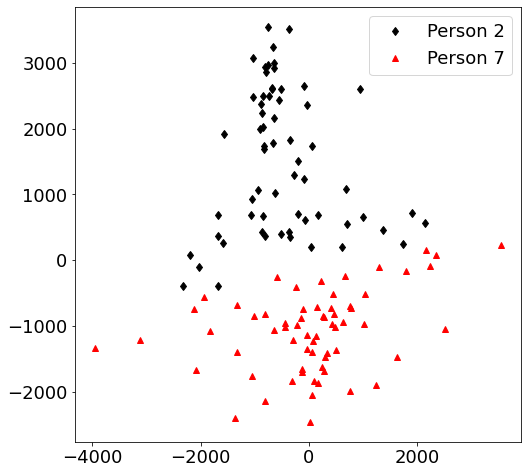

In [7]:
p1_num = 2  # Person number 2
p2_num = 7  # Person number 7

pc1 = 5
pc2 = 6

p1 = training_faces[:, np.sum(n_faces[:(p1_num - 1)]):np.sum(n_faces[:p1_num])]
p2 = training_faces[:, np.sum(n_faces[:(p2_num - 1)]):np.sum(n_faces[:p2_num])]

p1 = p1 - np.tile(avg_face, (p1.shape[1], 1)).T
p2 = p2 - np.tile(avg_face, (p2.shape[1], 1)).T

PCA_modes = [pc1, pc2]  # Project onto PCA modes 5 and 6
PCA_coordinates_P1 = U[:, PCA_modes - np.ones_like(PCA_modes)].T @ p1
PCA_coordinates_P2 = U[:, PCA_modes - np.ones_like(PCA_modes)].T @ p2

plt.plot(PCA_coordinates_P1[0, :], PCA_coordinates_P1[1, :], 'd', color='black', label='Person 2')
plt.plot(PCA_coordinates_P2[0, :], PCA_coordinates_P2[1, :], '^', color='red', label='Person 7')

plt.legend()
plt.show()